In [1]:
from typing import Annotated, List, Literal, TypedDict
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

In [2]:
class State(TypedDict):
    nlist: Annotated[list[str], operator.add]


In [3]:

def nodeA(state: State) -> Command[Literal["nodeB", "nodeC", END]]:
    print(f"received state in nodeA: {state}")
    select = state["nlist"][-1]
    if select == "b":
        next_node = "nodeB"
    elif select == "c":
        next_node = "nodeC"
    elif select == "q": 
        next_node = END
    else:
        hil = interrupt(f"Invalid Input {select}")
        print(f"hil: {hil}")
        if hil == "ok":
            print("inside ok")
            select = "b"
            next_node = nodeB
        else:
            next_node = END
            select = "q"

    return Command(
        update = State(nlist = [select]), 
        goto = [next_node])

# def nodeA(state: State) -> State:
#     print(f"received state in nodeA: {state}")
#     return 

def nodeB(state: State) -> State:
    print(f"received state in nodeB: {state}")
    return State(nlist=["B"])

def nodeC(state: State) -> State:
    print(f"received state in nodeC: {state}")
    return State(nlist=["C"])



In [4]:
# def conditional_edge(state: State) -> Literal["nodeB", "nodeC", END]:
#     select = state["nlist"][-1]
#     if select == "b":
#         next_node = "nodeB"
#     elif select == "c":
#         next_node = "nodeC"
#     elif select == "q": 
#         next_node = END
#     else:
#         next_node = END

#     return next_node       
    

In [5]:
builder = StateGraph(State)
builder.add_node("nodeA", nodeA)

builder.add_node("nodeB", nodeB)
builder.add_node("nodeC", nodeC)


builder.add_edge(START, "nodeA")
builder.add_edge("nodeB", END)
builder.add_edge("nodeC", END)
# builder.add_conditional_edges("nodeA", conditional_edge)

graph = builder.compile()


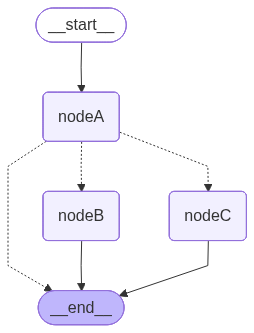

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# user = input("enter b,c or q to end the program")

# init_state = State(nlist=[user])
# graph.invoke(init_state)

Memory implementation


In [8]:
from langgraph.checkpoint.memory import InMemorySaver
memory= InMemorySaver()
config = {"configurable": {"thread_id": "1"}}
graph = builder.compile(checkpointer=memory)

In [9]:
# config = {"configurable": {"thread_id": "5"}}

In [10]:
while True:
    select = input("select b,c or q to end the program")
    print(select)
    input_state = State(nlist = [select])
    result = graph.invoke(input_state, config=config)
    print(result)

    if '__interrupt__' in result:
        print(f"inside interrupt:{result}")
        msg = result['__interrupt__'][-1].value
        print(msg)
        human = input(f"\n{msg}: ")

        human_response = Command(
            resume = human
        )
        result = graph.invoke(human_response, config)
    
    if result['nlist'][-1] == "q":
        print("quit")
        break
    

p
received state in nodeA: {'nlist': ['p']}
{'nlist': ['p'], '__interrupt__': [Interrupt(value='Invalid Input p', id='e8af233821073fa6790402192de9170b')]}
inside interrupt:{'nlist': ['p'], '__interrupt__': [Interrupt(value='Invalid Input p', id='e8af233821073fa6790402192de9170b')]}
Invalid Input p
received state in nodeA: {'nlist': ['p']}
hil: ok
inside ok
q
received state in nodeA: {'nlist': ['p', 'b', 'q']}
{'nlist': ['p', 'b', 'q', 'q']}
quit
